# Time Series with WTI Crude

West Texas Intermediate or WTI has spot price data at several locations for this example we are pulling from one of my favorite sources of 3rd party data the St. Louis Federal Reserve's Economic Research or FRED. In this case the data can be found via .csv from [WTI FRED Data](https://fred.stlouisfed.org/series/DCOILWTICO).

### So what's so signficant about WTI Crude?
In short this is America's oil. WTI is what is found in oil plays all around the United States. WTI is sometimes known as Texas light sweet as a grade of crude oil. It's a medium crude oil because of it's low density and it's sweet because of its low sulfur content.

The major trading hub for WTI is in a small town in the state of Oklahoma called Cushing, Oklahoma. Make no bones about it, Cushing, Oklahoma is a strategically important hub in U.S. Energy.

Now WTI can be quoted in 3 major locations:
* Midland, TX - This is the heart of Texas Oil Production
* Cushing, OK - Major transportation and storage hub
* Houston, TX - Where oil moves on to international markets

As someone who grew up and lived in Oklahoma, the oil and natural gas industry is vital to the citizens of that state. States like the Dakotas, Alaska, rural Texas, Wyoming depend on oil and natural gas for jobs and a strong macroeconomy. 

We often see when oil prices are up those economies are doing well and unemployement may be 3% or even around 2%. Other parts of the country however, consumers often see prices of one of their major commodities rise and they have the inverse problem as wages often don't move along with rising energy costs.

There are many reasons as to why we would want to forecast the price of WTI. I outlined a few of them. We did not cover geopolitics or banking, I'll leave that to another person.

## The Data

Like we explained in the above this data are from spot price in Cushing, OK via the FRED. The data is daily in nature. This is where we start coding.

In [13]:
# Packages
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import matplotlib
# ARIMA and other stat toys
import statsmodels.api as sm
# New shiny toy for forecasting
from fbprophet import Prophet
import itertools

In [14]:
df = pd.read_excel("wtiPrice.xlsx")

# Get our first few rows to check
df.head()

,DATE,DCOILWTICO
0,2013-10-01,102.09
1,2013-10-02,104.15
2,2013-10-03,103.29
3,2013-10-04,103.83
4,2013-10-07,103.07


So right off the bat we can see that this is business day data. No big deal.

I'm not going to create a daily forecast. We can let day traders or financial institutions do that, better word would be attempt. Daily forecast of commodities is tough. We are going to focus on some longer term forecast here. I'll dive a little deeper into forecasting as an art and science a little later.

#### Data Types

In [3]:
# Types of data
df.dtypes

DATE          datetime64[ns]
DCOILWTICO           float64
dtype: object

In [4]:
# How much of a time range do we have
# Use the Order date field and Min and Max function
df['DATE'].min(), df['DATE'].max()

(Timestamp('2013-10-01 00:00:00'), Timestamp('2018-10-01 00:00:00'))

In [5]:
df = df.groupby('DATE')['DCOILWTICO'].sum().reset_index()

# Set index 
df = df.set_index('DATE')
df.index

DatetimeIndex(['2013-10-01', '2013-10-02', '2013-10-03', '2013-10-04',
               '2013-10-07', '2013-10-08', '2013-10-09', '2013-10-10',
               '2013-10-11', '2013-10-14',
               ...
               '2018-09-18', '2018-09-19', '2018-09-20', '2018-09-21',
               '2018-09-24', '2018-09-25', '2018-09-26', '2018-09-27',
               '2018-09-28', '2018-10-01'],
              dtype='datetime64[ns]', name='DATE', length=1259, freq=None)

In [6]:
y = df['DCOILWTICO'].resample('MS').mean()
y['2016']

DATE
2016-01-01    31.683158
2016-02-01    30.323000
2016-03-01    37.546364
2016-04-01    40.755238
2016-05-01    46.712381
2016-06-01    48.757273
2016-07-01    44.651500
2016-08-01    44.724348
2016-09-01    45.182381
2016-10-01    49.775238
2016-11-01    45.660952
2016-12-01    51.970476
Freq: MS, Name: DCOILWTICO, dtype: float64

### Plot of Monthly WTI Price

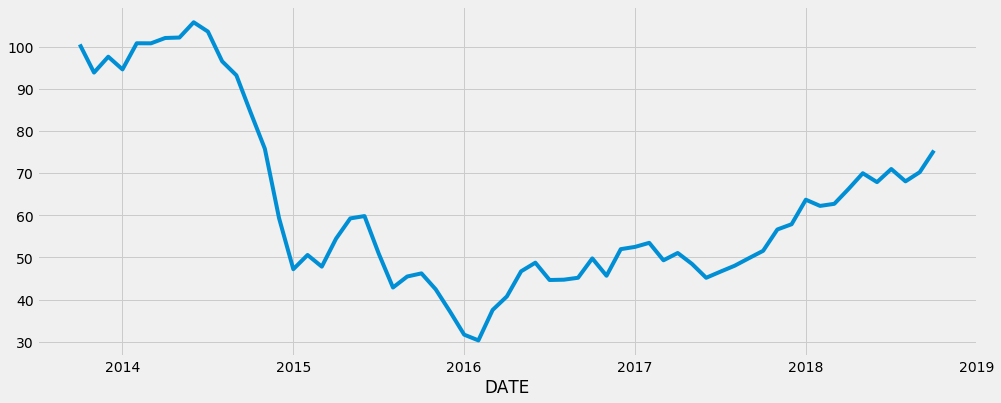

In [8]:
y.plot(figsize = (15, 6))
plt.show()

Our data starts back in Q4 of 2013. WTI was still rocking and rolling back in 2013. Not near the highs of 2012, but it was over a $100 a barrel. In 2014 the bottom fell out.

Some plays become unprofitable at certain dollar amounts. For example one of the most well known plays is profitable around 50 to 60 dollars a barrel. That may have changed so take that number with a grain of salt. Some other plays are only profitable at higher numbers like $80 a barrel.

The price drop in WTI in 2014 that continues has hit some states very hard. Most notable is Oklahoma. The Oklahoma economy is heavily dependent on the price of WTI.

### Back to the Plot for Time Series

This data is going to be a little rough, but we are going to power through it and see what we get. If we can't work with it, oh well. If we can great.

If the set was longer say 10 to 20 years this might be more optimal. However this is, well, what it is.

The modeling of WTI is not easy. We have a lot of unpredictably. We don't have seasonality from a visual test. We do have trend in upward movement since Q1 2016.

Without futher to do, let's take a look at a decomposition of our current time series.

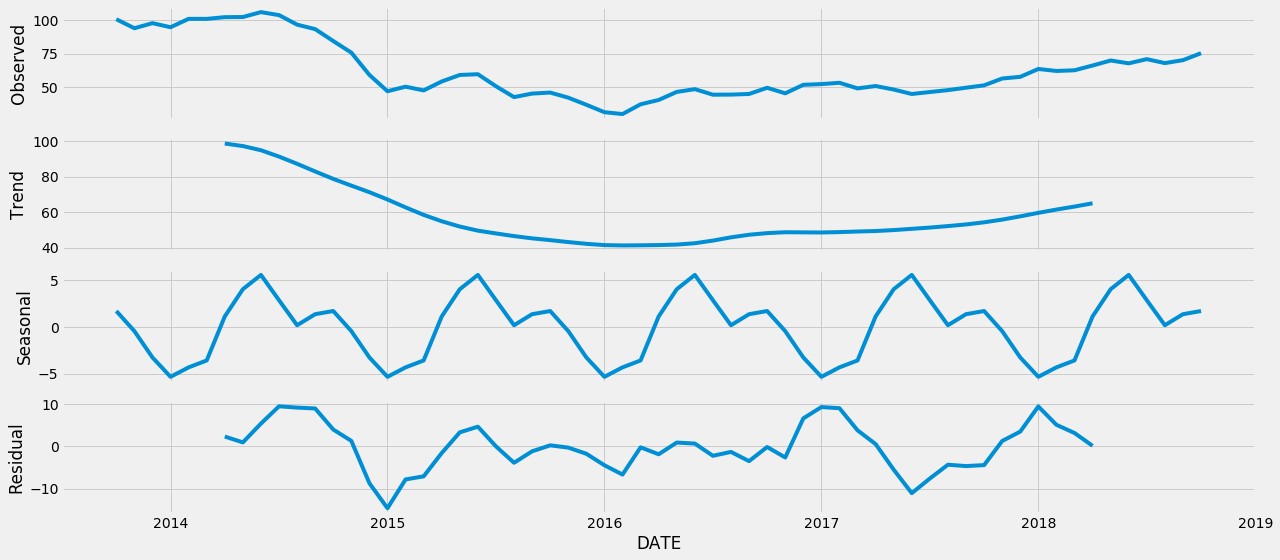

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model = 'additive')
fig = decomposition.plot()
plt.show()

Check out the seasonality. That was unexpected. Trend does what we thought it was going to do. Moving to the residual or our noise. It does not appear there is a pattern, so we can call this noise.

## Forecast and Parameter Selection

We are going to search for the optimal set of parameters to create a ARIMA model. To find it we are going to use a grid search. We will be using AIC to evalate the model. The below code is very sensitive to spacing.

In [15]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) 
                for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, 
                                            order=param,seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:523.0544360863069
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:294.9085933572481
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:441.6125105005027
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:436.13590551504194
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:309.86031149802034
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:298.7791344508006
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:588.7492700693067
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:425.3655089456564
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:392.51435279134745
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:259.38394267002775
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:391.10592775319355
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:381.1156975102909
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:281.8534539448318
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:263.7682969791966
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:283.55738021314284
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1227.9613838532575
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:291.32534347845433
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:285.542833787941
ARI

Our ARIMA model with an AIC of 218.71 is the model we are going to evaluate.

This model is defined by the below:
ARIMA(1, 0, 1)x(0, 1, 1, 12)12

Based on:
**ARIMA(_p_, _d_, _q_) x (_P_, _D_, _Q_) S**

where _p_ is a non-seasonal auto-regressive (AR) order
_d_ is non-seasonal differencing
_q_ is non-seasonal moving average (MA)

_P_ is seasonal AR order
_D_ is seasonal differncing
_Q_ is seasonal MA order

_and_
_S_ is the time span of a repeating seasonal pattern.

Help from [Penn State Stats](https://onlinecourses.science.psu.edu/stat510/node/67/)

So our model has a non-seasonal AR order of 1 and a non-seasonal MA of 1 with a seasonal AR order of 1 and sesonal MA order of 1 through 12 seasonal patterns, or months.

### Fitting the model

In [16]:
mod = sm.tsa.statespace.SARIMAX(y,
                               order = (1, 0, 1),
                               seasonal_order = (0, 1, 1, 12),
                               enforce_stationarity = False,
                               enforce_invertibility = False)
results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9176      0.061     15.152      0.000       0.799       1.036
ma.L1          0.0937      0.213      0.439      0.661      -0.324       0.512
ma.S.L12      -0.4914      0.284     -1.732      0.083      -1.048       0.065
sigma2        23.6226      6.425      3.677      0.000      11.030      36.215


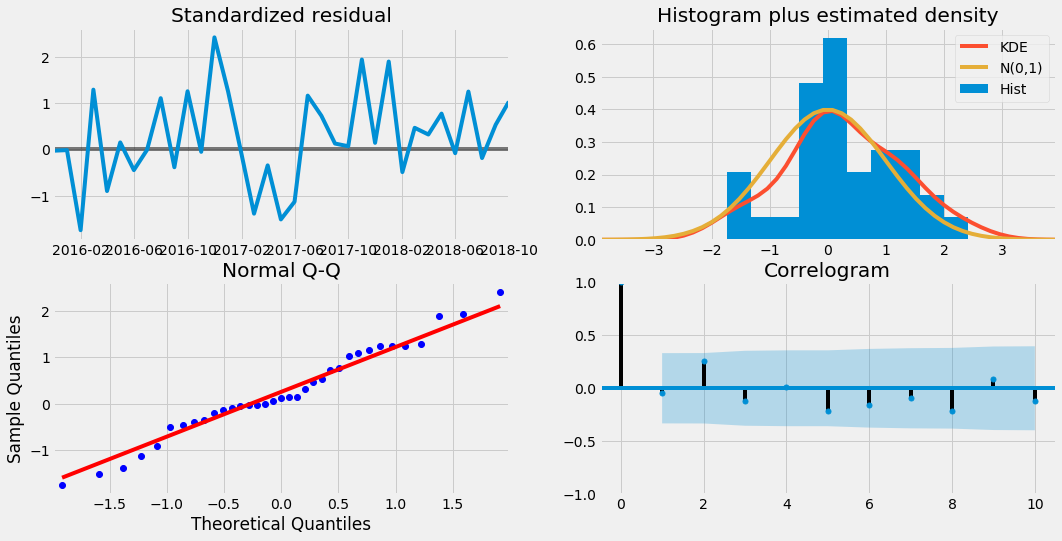

In [17]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

First, let us take a look at the historgram of the residuals. It's not pretty. However, the distribution is not terrible. The standardized residuals are likely above zero. This model however like all models is wrong, now, let's see if it is useful.

We are going to test the forecast on 2017 onwards to see how good the fit is. We are going to visualize the plot as well. 

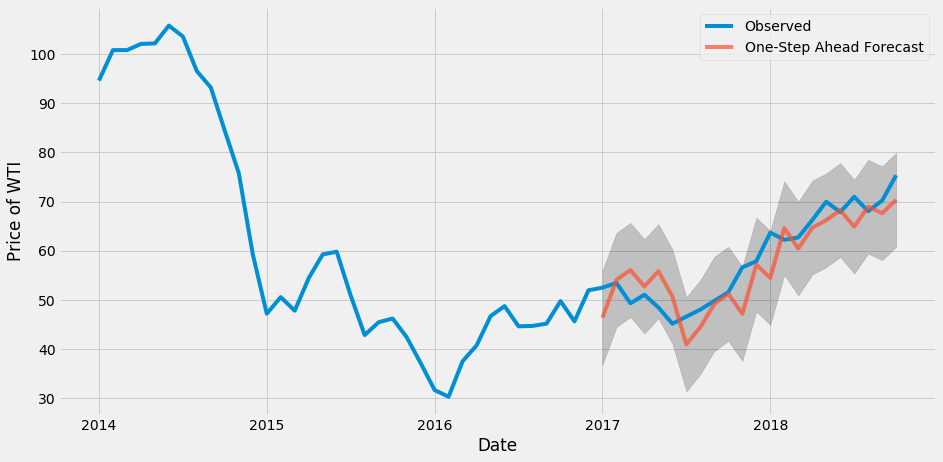

In [21]:
pred = results.get_prediction(start = pd.to_datetime('2017-01-01'),
                             dynamic = False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label = 'Observed')
pred.predicted_mean.plot(ax = ax, label = 'One-Step Ahead Forecast',
                        alpha = .7, figsize = (14, 7))

ax.fill_between(pred_ci.index,
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:, 1], color = 'k', alpha = .2)
ax.set_xlabel('Date')
ax.set_ylabel('Price of WTI')
plt.legend()

plt.show()

The model did better than I expected. It is not perfect, but it ran very close to actuals. If we were short term traders this model would not be our go for sure. If we are interested in longer term outlooks then this model is not bad.

To be sure we are going to take a look at the squared errors and Root Mean Squared Error of RMSE.

In [22]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The MSE of the WTI Forecast is {}'.format(round(mse, 2)))

print('The RMSE of the WTI Forecast is {}'.format(round(np.sqrt(mse), 2)))

The MSE of the WTI Forecast is 22.19
The RMSE of the WTI Forecast is 4.71


Our RMSE is 4.71 or $4.71. This means that the average daily price in the test set a few bucks off. It's important to note that this could be a good forecast or it could be a bad one. Are you buying thousands of barrels a day? If so you could be under or over forecasting by thousands of dollars a day.

Lets take a look at the start of 2017 (hindsight is 20x20) the price was around 50 dollars for a barrel. If we used our forecast we could have hedged and bought at 50. We would feel pretty good in Q